# System Setup

In [1]:
import numpy as np
import pandas as pd
import mdtraj as md
import nglview as nv
from glob import glob
from functions import *
import matplotlib.pyplot as plt

In [2]:
## The Atomic Radii used for SASA calculation
_ATOMIC_RADII = {'H'   : 0.120, 'He'  : 0.140, 'Li'  : 0.076, 'Be' : 0.059,
                 'B'   : 0.192, 'C'   : 0.170, 'N'   : 0.155, 'O'  : 0.152,
                 'F'   : 0.147, 'Ne'  : 0.154, 'Na'  : 0.102, 'Mg' : 0.086,
                 'Al'  : 0.184, 'Si'  : 0.210, 'P'   : 0.180, 'S'  : 0.180,
                'Ca'   : 0.200, 'Cl'  : 0.200, 'Zn'  : 0.200, 'VS' : 0.152,
                 'I'   : 0.220, 'Br'  : 0.196 , 'A'  : 0.170,}

# Docking from Vina

## Calculate BSA

In [3]:
# Path to receptor file
path2out = '../01_receptor_prep/hmx.B99990001.pdb'

# Load the file with mdtraj and convert to table
pdb = md.load(path2out)
table, _ = pdb.topology.to_dataframe()

# from the table get the atom indices, coords and elements for both proteins
A_ids = table.query('chainID == 0').index
B_ids = table.query('chainID == 1').index
A_xyz = pdb.xyz[:,A_ids]
B_xyz = pdb.xyz[:,B_ids]
A_elems = table.loc[A_ids,'element'].values
B_elems = table.loc[B_ids,'element'].values

# SASA calculation with external function 
### would be better if we wrote functions.Sasa_calc, then its clear where the function comes from
A_Radii    = [_ATOMIC_RADII[element] for element in A_elems]
B_Radii    = [_ATOMIC_RADII[element] for element in B_elems]  
A_SASA     = Sasa_calc(A_xyz,A_Radii)[0]
B_SASA     = Sasa_calc(B_xyz,B_Radii)[0]

In [4]:
# specify path to the ligands and the file count (thus the total number of ligands)
L_files = glob('../03_docking_prep/PDB/*[0-9]_1.pdb')
L_count = len(L_files)

# Initialise Arrays with the total ligand count
L_id = np.zeros(L_count,dtype=int)
mode = np.zeros(L_count,dtype=int)
score = np.zeros(L_count)
L_SASA = np.zeros(L_count)
AL_SASA = np.zeros(L_count)
BL_SASA = np.zeros(L_count)

# Loop over all Ligand files in the directory specified in the glob argument
for i, L_file in enumerate(L_files):
    
    # use the file to load the ligand with mdtraj and extract meta information and Docking Score
    L = md.load(L_file)
    L_id[i] = L_file.split('_')[-2]
    mode[i] = L_file.split('_')[-1].split('.pdb')[0]
    score[i] = read_output(L_file, pattern=vina_pattern)[0]
    
    # Calculate the SASAs from the protein and Ligand informations read by MDtraj and the hardcoded Radii
    L_Radii = [_ATOMIC_RADII[atom.element.symbol] for atom in L.topology.atoms] 
    L_SASA[i] = Sasa_calc(L.xyz,L_Radii)[0]
    AL_SASA[i] = Sasa_calc(np.concatenate([A_xyz, L.xyz],axis=1),A_Radii + L_Radii)[0]
    BL_SASA[i] = Sasa_calc(np.concatenate([B_xyz, L.xyz],axis=1),B_Radii + L_Radii)[0]

In [5]:
# define data and columns for proper Pocket data table
L_data = np.array([score, L_SASA, AL_SASA, BL_SASA]).T
L_cols = ['D_Score','SASA_L','SASA_AL','SASA_BL']

# Create Data table and calculate additional properties important for identification of good ligands
df_L = pd.DataFrame(L_data, columns=L_cols)
df_L['Ligand'] = L_id
df_L['BSA_AL'] = L_SASA + A_SASA - AL_SASA
df_L['BSA_BL'] = L_SASA + B_SASA - BL_SASA
df_L['BSA_min'] = df_L[['BSA_AL','BSA_BL']].values.min(axis=1)

In [6]:
df_L.head()

,D_Score,SASA_L,SASA_AL,SASA_BL,Ligand,BSA_AL,BSA_BL,BSA_min
0,-6.1,418.100037,18848.199219,12509.400391,1,283.400818,400.898865,283.400818
1,-5.2,458.900024,18923.398438,12459.900391,87585,249.001587,491.198853,249.001587
2,-5.8,421.700012,18863.000000,12507.700195,199888,272.200012,406.199036,272.200012
3,-5.1,392.700012,18901.300781,12505.400391,0,204.899231,379.498840,204.899231
4,-5.5,356.800018,18865.000000,12471.000000,139,205.300018,377.999237,205.300018


In [7]:
## Get only Interface ligand with buried Surface area greater than 20
df_L.query('BSA_min > 20')

,D_Score,SASA_L,SASA_AL,SASA_BL,Ligand,BSA_AL,BSA_BL,BSA_min
0,-6.1,418.100037,18848.199219,12509.400391,1,283.400818,400.898865,283.400818
1,-5.2,458.900024,18923.398438,12459.900391,87585,249.001587,491.198853,249.001587
2,-5.8,421.700012,18863.000000,12507.700195,199888,272.200012,406.199036,272.200012
3,-5.1,392.700012,18901.300781,12505.400391,0,204.899231,379.498840,204.899231
4,-5.5,356.800018,18865.000000,12471.000000,139,205.300018,377.999237,205.300018
5,-5.6,392.899994,18871.898438,12465.000000,75,234.501556,420.099213,234.501556
6,-4.7,380.600006,18865.199219,12451.899414,6,228.900787,420.899811,228.900787
7,-5.1,396.900024,18880.599609,12506.799805,18,229.800415,382.299438,229.800415


## Data Visualization

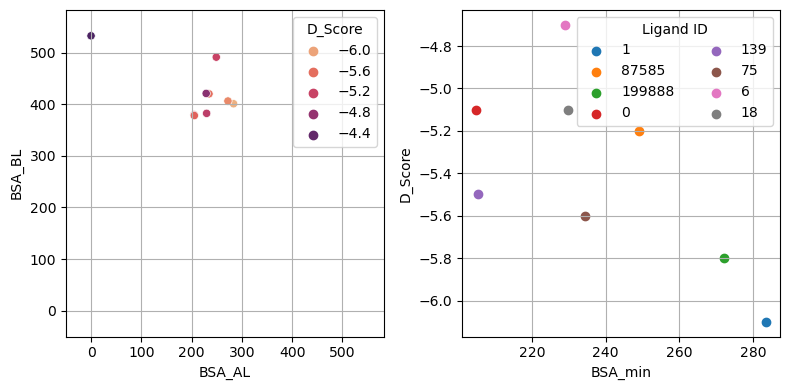

In [8]:
# Plot the BSA metrics and save the figure
fig, axs = plt.subplots(1,2,figsize=(8,4))
plot_BSA_Score(df_L, 
               xcol='BSA_AL',
               ycol='BSA_BL',
               min_col='BSA_min',
               score='D_Score', 
               plot_margin = 50,
               axs = axs)
plt.savefig('VinaTest_BSA_dockingscore.jpeg', dpi=450)

## Structure Visualization

In [9]:
# Visualisation to make sure the ligand is good for real
# Change L_path for different ligands or different modes; e.g: out_1_3, out_1_3, or out_18_3, out_18_9
AB_path = '../01_receptor_prep/hmx.B99990001.pdb'
L_path='../03_docking_prep/PDB/out_1_1.pdb'
AB = md.load(AB_path)
view = nv.show_mdtraj(AB)
show_ligand(view,L_path)
view

NGLWidget()